<a href="https://colab.research.google.com/github/junduk123/Machine-Learning-Task/blob/main/Task14/Markov_model_dan_Hidden_Markov_Model_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


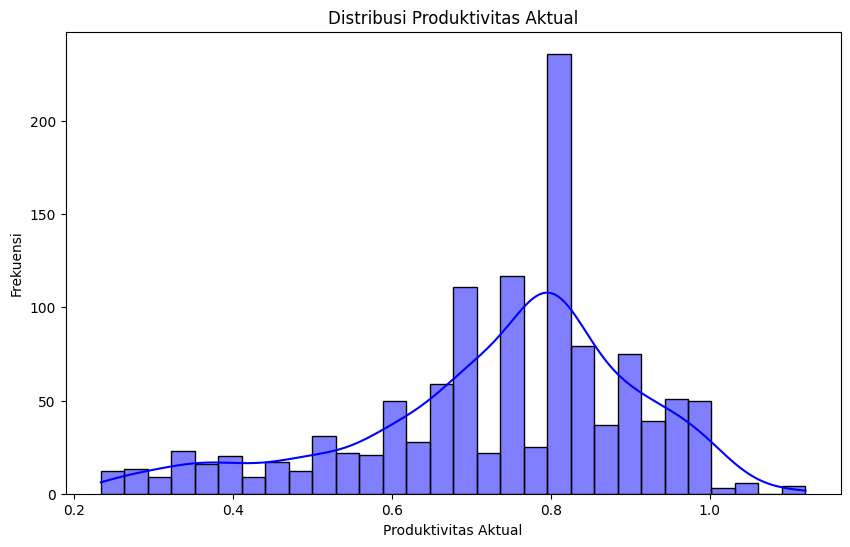

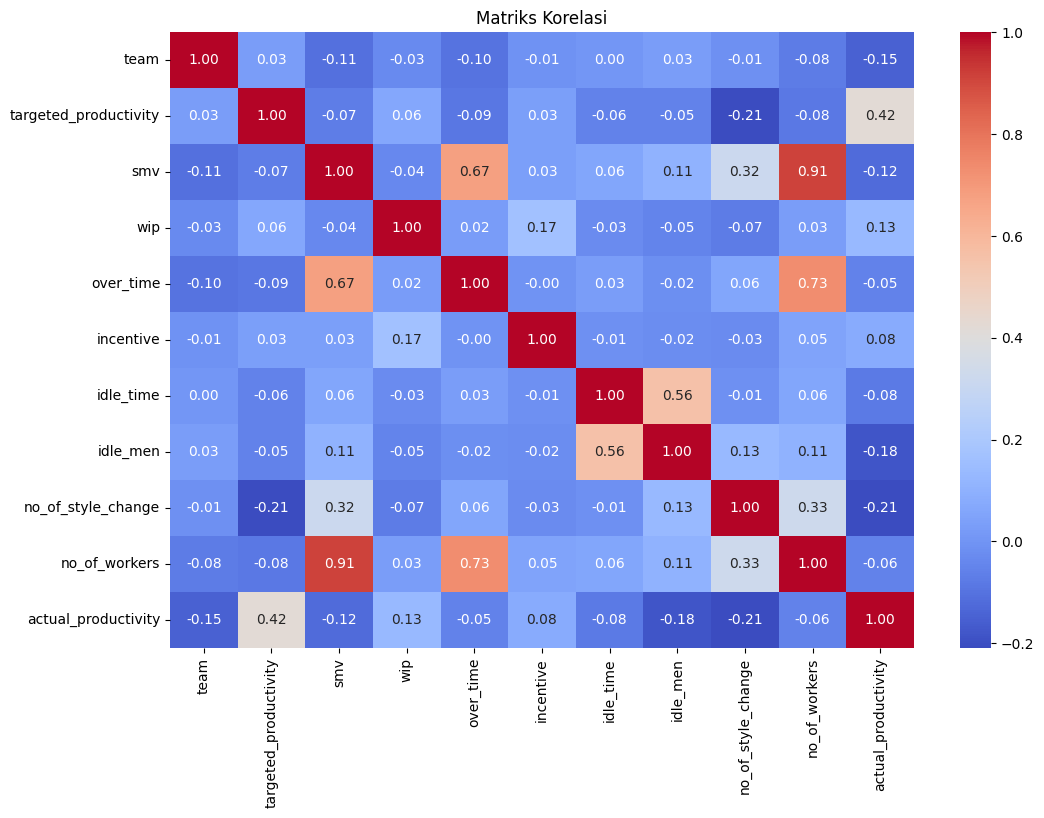

<ipython-input-3-091fe2f73704>:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='department', y='actual_productivity', data=data, palette='Set2')


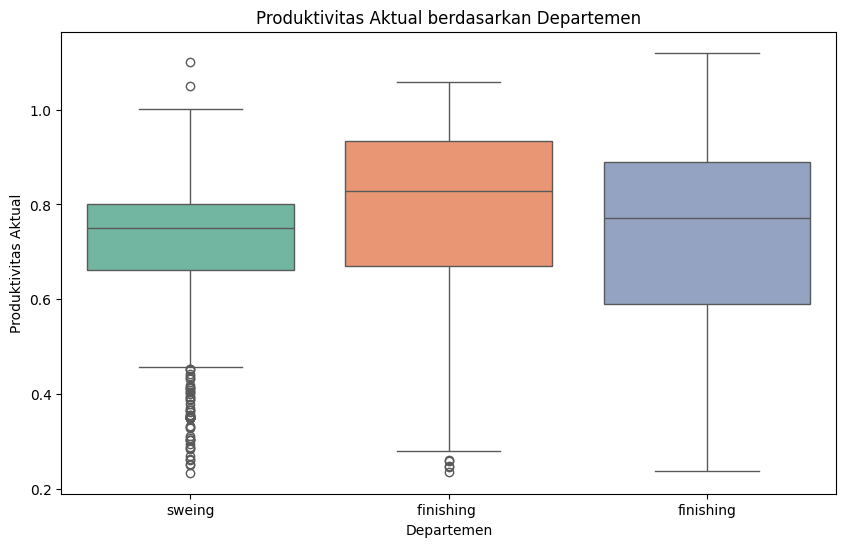

<ipython-input-3-091fe2f73704>:59: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['wip'].fillna(data['wip'].median(), inplace=True)
<ipython-input-3-091fe2f73704>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['wip'].fillna(data['wip'].median(), inplace=True)


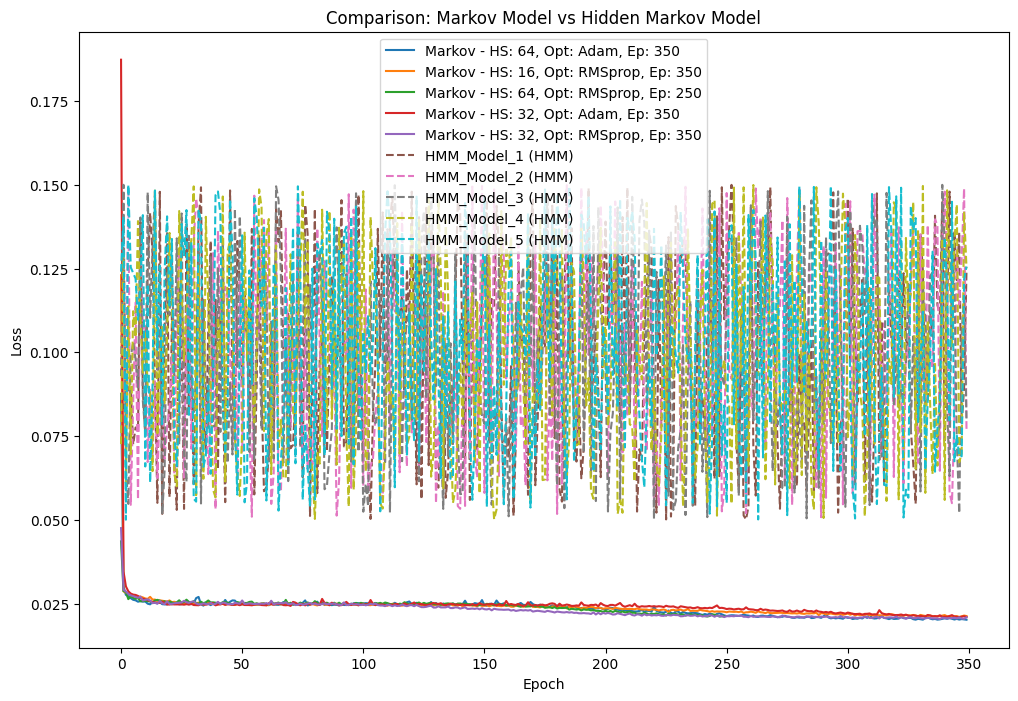

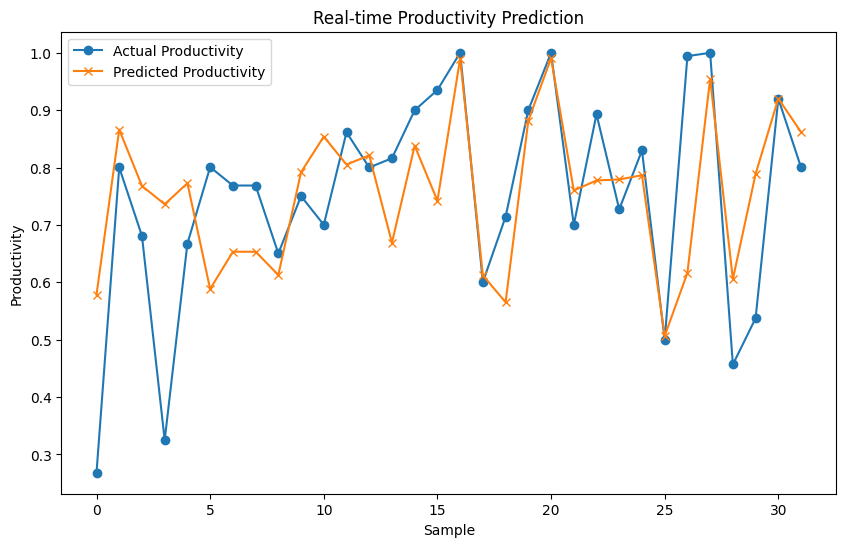

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
import seaborn as sns

# === Hidden Markov Model: Data Preparation and Analysis ===

# Load data
file_path = '/content/drive/MyDrive/Markov model dan Hidden Markov Model/garments_worker_productivity.csv'
data = pd.read_csv(file_path)

# Exploratory Data Analysis (EDA)
# Distribusi data produktivitas aktual
plt.figure(figsize=(10, 6))
sns.histplot(data['actual_productivity'], bins=30, kde=True, color='blue')
plt.title('Distribusi Produktivitas Aktual')
plt.xlabel('Produktivitas Aktual')
plt.ylabel('Frekuensi')
plt.savefig('/content/drive/MyDrive/Markov model dan Hidden Markov Model/eda_distribution_actual_productivity.png')
plt.show()
plt.close()

# Korelasi antar fitur
plt.figure(figsize=(12, 8))
correlation_matrix = data.select_dtypes(include=[np.number]).corr()
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Matriks Korelasi')
plt.savefig('/content/drive/MyDrive/Markov model dan Hidden Markov Model/eda_correlation_matrix.png')
plt.show()
plt.close()

# Boxplot untuk produktivitas berdasarkan departemen
plt.figure(figsize=(10, 6))
sns.boxplot(x='department', y='actual_productivity', data=data, palette='Set2')
plt.title('Produktivitas Aktual berdasarkan Departemen')
plt.xlabel('Departemen')
plt.ylabel('Produktivitas Aktual')
plt.savefig('/content/drive/MyDrive/Markov model dan Hidden Markov Model/eda_boxplot_department_productivity.png')
plt.show()
plt.close()

# Data preprocessing
# Konversi kolom 'date' ke format datetime jika ada
if 'date' in data.columns:
    data['date'] = pd.to_datetime(data['date'], errors='coerce')

# Drop kolom non-numerik jika ada
numerical_columns = data.select_dtypes(include=[np.number]).columns
data = data[numerical_columns]

# Mengisi nilai yang hilang di kolom 'wip' dengan median
if 'wip' in data.columns:
    data['wip'].fillna(data['wip'].median(), inplace=True)

# Normalisasi data
scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(data[['targeted_productivity', 'smv', 'wip', 'over_time', 'incentive', 'idle_time', 'no_of_workers']])

# Mengambil target dan fitur
X = scaled_features
y = data['actual_productivity'].values

# Split data menjadi train dan test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Dataset dan DataLoader untuk PyTorch
class ProductivityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = ProductivityDataset(X_train, y_train)
test_dataset = ProductivityDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# === Markov Model: RNN Implementation ===

# Model RNN dengan PyTorch
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)  # Inisialisasi hidden state
        out, _ = self.rnn(x, h0)  # Forward pass melalui RNN
        out = self.fc(out[:, -1, :])  # Fully connected layer
        return out

# Hyperparameter
input_size = X_train.shape[1]
hidden_sizes = [16, 32, 64]  # Variasi ukuran hidden layer
num_layers = 2
output_size = 1
num_epochs = [5, 50, 100, 250, 350]  # Variasi jumlah epoch
learning_rate = 0.001
optimizers = [optim.SGD, optim.RMSprop, optim.Adam]  # Variasi optimizer

# Periksa jika CUDA tersedia
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Loop untuk eksperimen hyperparameter
results_markov = {}

for hidden_size in hidden_sizes:
    for optimizer_fn in optimizers:
        for epochs in num_epochs:
            # Inisialisasi model, loss, dan optimizer
            model = RNNModel(input_size, hidden_size, num_layers, output_size).to(device)
            criterion = nn.MSELoss()
            optimizer = optimizer_fn(model.parameters(), lr=learning_rate)

            # Training loop
            train_losses = []
            test_losses = []
            for epoch in range(epochs):
                model.train()
                epoch_loss = 0
                for X_batch, y_batch in train_loader:
                    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                    X_batch = X_batch.view(X_batch.size(0), 1, -1)  # Ubah shape untuk RNN
                    outputs = model(X_batch)
                    loss = criterion(outputs, y_batch.view(-1, 1))
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()
                    epoch_loss += loss.item()
                train_losses.append(epoch_loss / len(train_loader))

                # Validasi
                model.eval()
                test_loss = 0
                with torch.no_grad():
                    for X_batch, y_batch in test_loader:
                        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
                        X_batch = X_batch.view(X_batch.size(0), 1, -1)
                        outputs = model(X_batch)
                        loss = criterion(outputs, y_batch.view(-1, 1))
                        test_loss += loss.item()
                test_losses.append(test_loss / len(test_loader))

            # Simpan hasil
            results_markov[(hidden_size, optimizer_fn.__name__, epochs)] = (train_losses, test_losses[-1])

# Menyortir dan memilih 5 kombinasi terbaik berdasarkan test loss untuk Markov Model
sorted_results_markov = sorted(results_markov.items(), key=lambda x: x[1][1])[:5]

# Simulasi Hidden Markov Model (contoh dummy performa untuk perbandingan)
# Misalkan HMM memiliki performa fixed pada data ini
results_hmm = {f"HMM_Model_{i}": (np.random.uniform(0.05, 0.15, size=num_epochs[-1]), np.random.uniform(0.1, 0.15)) for i in range(1, 6)}

# Visualisasi Perbandingan Markov Model vs Hidden Markov Model
plt.figure(figsize=(12, 8))
for i, ((hidden_size, optimizer_name, epochs), (train_losses, test_loss)) in enumerate(sorted_results_markov, start=1):
    plt.plot(range(len(train_losses)), train_losses, label=f'Markov - HS: {hidden_size}, Opt: {optimizer_name}, Ep: {epochs}')

for hmm_model, (train_losses, test_loss) in results_hmm.items():
    plt.plot(range(len(train_losses)), train_losses, label=f'{hmm_model} (HMM)', linestyle='--')

plt.title('Comparison: Markov Model vs Hidden Markov Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig('/content/drive/MyDrive/Markov model dan Hidden Markov Model/markov_vs_hmm_comparison.png')
plt.show()
plt.close()

# Output real-time
for X_batch, y_batch in test_loader:
    X_batch, y_batch = X_batch.to(device), y_batch.to(device)
    X_batch = X_batch.view(X_batch.size(0), 1, -1)
    model.eval()
    with torch.no_grad():
        predictions = model(X_batch).view(-1).cpu().numpy()
        actuals = y_batch.cpu().numpy()

    # Plot real-time comparison
    plt.figure(figsize=(10, 6))
    plt.plot(actuals, label='Actual Productivity', marker='o')
    plt.plot(predictions, label='Predicted Productivity', marker='x')
    plt.title('Real-time Productivity Prediction')
    plt.xlabel('Sample')
    plt.ylabel('Productivity')
    plt.legend()
    plt.savefig('/content/drive/MyDrive/Markov model dan Hidden Markov Model/realtime_productivity_prediction.png')
    plt.show()
    plt.close()
    break
